<a href="https://colab.research.google.com/github/profsuccodifrutta/Variational_Autoencoder_for_Anomaly_Detection/blob/main/third_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import os
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Crea una cartella locale su Colab per i dati (veloce)
!mkdir -p /content/dataset_local

# Scompatta il file.
path_zip = "/content/drive/MyDrive/brainmri.zip"

!unzip -q "{path_zip}" -d /content/dataset_local

print("Scompattamento completato!")

Scompattamento completato!


In [ ]:
# cosa c'è dentro cartella locale
#!ls -R /content/dataset_local

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

import os
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms

In [4]:
import glob
import os
import torch
from PIL import Image
from torch.utils.data import Dataset, random_split

# 1. Puntiamo ai dati sani
file_sani = glob.glob("/content/dataset_local/**/Training/notumor/*.jpg", recursive=True)

print(f"--- ANALISI DATASET ---")
print(f"Totale immagini sane trovate: {len(file_sani)}")

# 2. Classe Dataset
class BrainDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        image = Image.open(img_path).convert('L')
        if self.transform:
            image = self.transform(image)
        return image

# 3. Creazione Split (70% Train, 20% Val, 10% Test)
if len(file_sani) > 0:
    full_healthy_ds = BrainDataset(file_sani)

    train_size = int(0.7 * len(full_healthy_ds))
    val_size = int(0.2 * len(full_healthy_ds))
    test_size = len(full_healthy_ds) - train_size - val_size

    train_subset, val_subset, test_healthy_subset = random_split(
        full_healthy_ds, [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )

    print(f"\n--- DISTRIBUZIONE SPLIT (Solo Sani) ---")
    print(f"✅ Training:   {len(train_subset)} immagini (usate per imparare la normalità)")
    print(f"⚠️ Validation: {len(val_subset)} immagini (usate per monitorare l'allenamento)")
    print(f"🛡️ Test Sani:  {len(test_healthy_subset)} immagini (usate per valutare i falsi allarmi)")

    # 4. Recuperiamo le anomalie per il Test finale
    file_anomalie = glob.glob("/content/dataset_local/**/Testing/*/*.jpg", recursive=True)
    # Filtriamo via i sani dalla cartella Testing per avere solo anomalie vere
    file_anomalie = [f for f in file_anomalie if "notumor" not in f]

    print(f"\n--- DATI PER TEST ANOMALIE ---")
    print(f"🚨 Anomalie:  {len(file_anomalie)} immagini (glioma, meningioma, etc.)")
else:
    print("❌ ERRORE: Non ho trovato le immagini. Controlla se la cartella 'Training/notumor' esiste.")

--- ANALISI DATASET ---
Totale immagini sane trovate: 1595

--- DISTRIBUZIONE SPLIT (Solo Sani) ---
✅ Training:   1116 immagini (usate per imparare la normalità)
⚠️ Validation: 319 immagini (usate per monitorare l'allenamento)
🛡️ Test Sani:  160 immagini (usate per valutare i falsi allarmi)

--- DATI PER TEST ANOMALIE ---
🚨 Anomalie:  906 immagini (glioma, meningioma, etc.)


In [21]:
# Controlliamo la dimensione reale della prima immagine del dataset
img_raw = Image.open(train_subset.dataset.file_list[0])
print(f"La dimensione originale dei file è: {img_raw.size}")

La dimensione originale dei file è: (225, 225)


In [33]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

# 1. trasformazioni
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
])

base_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# 2. DEFINIZIONE DATASET (Se non l'hai eseguita sopra, la mettiamo qui per sicurezza)
class BrainDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform
    def __len__(self):
        return len(self.file_list)
    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        image = Image.open(img_path).convert('L')
        if self.transform:
            image = self.transform(image)
        return image

# 3. CREAZIONE DEI DATALOADERS
batch_size = 8

# Recupero percorsi dai subset (assicurati di aver eseguito lo split prima!)
file_train_paths = [train_subset.dataset.file_list[i] for i in train_subset.indices]
file_val_paths = [val_subset.dataset.file_list[i] for i in val_subset.indices]
file_sani_test_paths = [test_healthy_subset.dataset.file_list[i] for i in test_healthy_subset.indices]

# Inizializzazione Loader
train_loader = DataLoader(BrainDataset(file_train_paths, transform=train_transform), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(BrainDataset(file_val_paths, transform=base_transform), batch_size=batch_size, shuffle=False)
test_loader_sani = DataLoader(BrainDataset(file_sani_test_paths, transform=base_transform), batch_size=batch_size, shuffle=False)
anno_loader = DataLoader(BrainDataset(file_anomalie, transform=base_transform), batch_size=batch_size, shuffle=False)

print(f"✅ Configurazione completata!")
print(f"Train: {len(file_train_paths)} | Test Sani: {len(file_sani_test_paths)} | Anomalie: {len(file_anomalie)}")

✅ Configurazione completata!
Train: 1116 | Test Sani: 160 | Anomalie: 906


Formato del batch (Batch_size, Canali, Altezza, Larghezza): torch.Size([16, 1, 224, 224])


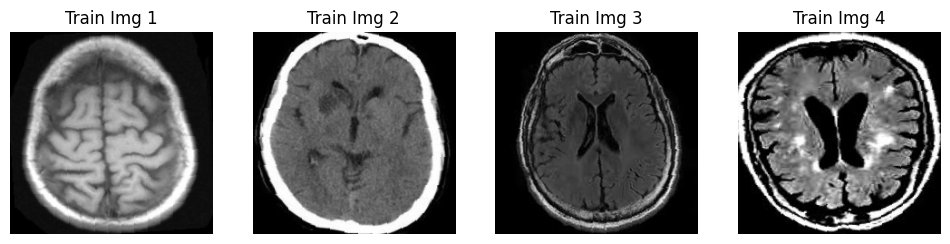

In [27]:
import matplotlib.pyplot as plt

# Estraiamo un batch (32 immagini) dal nostro motore di caricamento
images = next(iter(train_loader))

print(f"Formato del batch (Batch_size, Canali, Altezza, Larghezza): {images.shape}")

# Visualizziamo le prime 4 immagini per vedere l'effetto delle trasformazioni
plt.figure(figsize=(12, 6))
for i in range(4):
    plt.subplot(1, 4, i+1)
    # Squeeze serve per passare da (1, 128, 128) a (128, 128) per il plot
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f"Train Img {i+1}")
    plt.axis('off')
plt.show()

In [38]:
class VAE_V3(nn.Module):
    def __init__(self, latent_dim=1024):
        super(VAE_V3, self).__init__()

        # ENCODER (Input: 1 x 224 x 224)
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2), # -> 112x112
            nn.Dropout2d(0.1),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2), # -> 56x56

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2), # -> 28x28

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2), # -> 14x14  <-- L'encoder si ferma qui
            nn.Flatten()     # 512 * 14 * 14 = 100352
        )

        # Usiamo il numero magico 100352
        self.fc_mu = nn.Linear(100352, latent_dim)
        self.fc_logvar = nn.Linear(100352, latent_dim)

        # DECODER
        self.decoder_input = nn.Linear(latent_dim, 100352)

        self.decoder = nn.Sequential(
            # Partiamo da 14x14
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1), # -> 28x28
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1), # -> 56x56
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1), # -> 112x112
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(64, 1, kernel_size=3, stride=2, padding=1, output_padding=1), # -> 224x224
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        encoded = self.encoder(x)
        mu = self.fc_mu(encoded)
        logvar = self.fc_logvar(encoded)
        z = self.reparameterize(mu, logvar)

        #  ripristinare la forma 512x14x14
        de_input = self.decoder_input(z).view(-1, 512, 14, 14)
        reconstruction = self.decoder(de_input)
        return reconstruction, mu, logvar

In [39]:
import torch.nn.functional as F
import time

def loss_function_v3(recon_x, x, mu, logvar, beta=0.01): # Beta aumentato
    # Errore di ricostruzione (MSE)
    recon_loss = F.mse_loss(recon_x, x, reduction='mean')

    # KL Divergence
    kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    # La combinazione pesata
    return recon_loss + (beta * kl_loss), recon_loss, kl_loss


In [40]:
import matplotlib.pyplot as plt

def visualize_reconstruction(model, loader):
    model.eval()
    with torch.no_grad():
        # Prende un batch dal loader
        data = next(iter(loader))
        data = data.to(device)

        # Ottiene la ricostruzione
        recon, _, _ = model(data)

        # Plot dei primi 2 esempi
        fig, axes = plt.subplots(2, 2, figsize=(10, 8))
        for i in range(2):
            # Originale
            axes[i, 0].imshow(data[i].cpu().squeeze(), cmap='gray')
            axes[i, 0].set_title("Originale")
            axes[i, 0].axis('off')

            # Ricostruito
            axes[i, 1].imshow(recon[i].cpu().squeeze(), cmap='gray')
            axes[i, 1].set_title("Recon V2")
            axes[i, 1].axis('off')
        plt.show()

In [43]:
# --- CELLA DI INIZIALIZZAZIONE V3 ---
# 1. Spostiamo il modello sulla GPU (usando la classe VAE_V3 definita sopra)
model = VAE_V3(latent_dim=1024).to(device)

# 2. Definiamo l'Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# 3. Definiamo lo SCHEDULER (Fondamentale per la V3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=5
)

# 4. Inizializziamo la variabile per il salvataggio
best_val_loss = float('inf')

print("✅ Modello, Optimizer e Scheduler pronti!")
print(f"Dispositivo utilizzato: {device}")

✅ Modello, Optimizer e Scheduler pronti!
Dispositivo utilizzato: cuda


In [ ]:
import torch

# Definiamo il dispositivo una volta per tutte
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"✅ Dispositivo configurato: {device}")
if device.type == 'cuda':
    print(f"🚀 GPU rilevata: {torch.cuda.get_device_name(0)}")
else:
    print("⚠️ ATTENZIONE: GPU non trovata. Il training sarà lentissimo su CPU!")

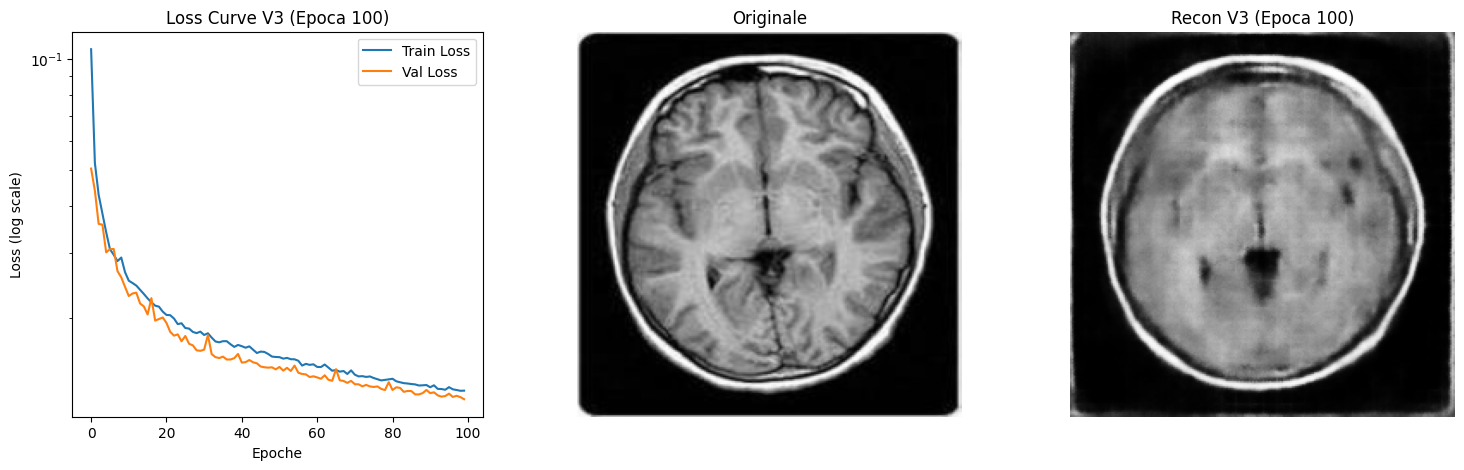

Epoca [100/100] | Train: 0.012714 | Val: 0.012054 | LR: 1.0e-04
✨ Miglior modello V3 salvato!


In [44]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import torch.nn.utils as utils

# --- CONFIGURAZIONE V3 ---
save_path_v3 = "/content/drive/MyDrive/VAE_Brain_Project/best_model_v3.pth"
train_losses = []
val_losses = []
best_val_loss = float('inf')
beta_val = 0.01  # Beta aumentato per forzare la regolarizzazione
num_epochs = 100

print(f"Inizio Training V3 su {device}...")

for epoch in range(num_epochs):
    # --- FASE DI TRAINING ---
    model.train()
    train_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()

        recon, mu, logvar = model(batch)

        # Usiamo la nuova loss function V3
        loss, mse, kl = loss_function_v3(recon, batch, mu, logvar, beta=beta_val)

        loss.backward()

        # 1. GRADIENT CLIPPING: Impedisce ai gradienti di esplodere
        utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        train_loss += loss.item()

    avg_train = train_loss / len(train_loader)
    train_losses.append(avg_train)

    # --- FASE DI VALIDAZIONE ---
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            recon, mu, logvar = model(batch)
            loss, _, _ = loss_function_v3(recon, batch, mu, logvar, beta=beta_val)
            val_loss += loss.item()

    avg_val = val_loss / len(val_loader)
    val_losses.append(avg_val)

    # Aggiornamento Scheduler
    scheduler.step(avg_val)

    # Salvataggio miglior modello V3
    if avg_val < best_val_loss:
        best_val_loss = avg_val
        torch.save(model.state_dict(), save_path_v3)
        status_save = "✨ Miglior modello V3 salvato!"
    else:
        status_save = ""

    # --- VISUALIZZAZIONE OGNI 10 EPOCHE ---
    if (epoch + 1) % 10 == 0 or epoch == 0:
        clear_output(wait=True)

        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

        # 1. Plot delle Loss (Scala Logaritmica per chiarezza)
        ax1.plot(train_losses, label='Train Loss')
        ax1.plot(val_losses, label='Val Loss')
        ax1.set_yscale('log') # Rende visibili i dettagli anche con picchi alti
        ax1.set_title(f"Loss Curve V3 (Epoca {epoch+1})")
        ax1.set_xlabel("Epoche")
        ax1.set_ylabel("Loss (log scale)")
        ax1.legend()

        # 2. Visualizzazione Ricostruzione
        with torch.no_grad():
            sample_batch = next(iter(val_loader)).to(device)
            sample_recon, _, _ = model(sample_batch)

            ax2.imshow(sample_batch[0].cpu().squeeze(), cmap='gray')
            ax2.set_title("Originale")
            ax2.axis('off')

            ax3.imshow(sample_recon[0].cpu().squeeze(), cmap='gray')
            ax3.set_title(f"Recon V3 (Epoca {epoch+1})")
            ax3.axis('off')

        plt.show()

        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoca [{epoch+1}/{num_epochs}] | Train: {avg_train:.6f} | Val: {avg_val:.6f} | LR: {current_lr:.1e}")
        print(status_save)

In [46]:
# caricamento rapido del modello V3 (Aggiornato)

from google.colab import drive
import torch

# 1. Monta il Drive
drive.mount('/content/drive')

# 2. Definisci il dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 3. Inizializza il modello V3
# IMPORTANTE: Assicurati di aver eseguito prima la cella con la definizione di class VAE_V3
model = VAE_V3(latent_dim=1024).to(device)

# 4. Carica i pesi salvati della V3
# Il percorso ora punta al nuovo file salvato dalla cella di training V3
model_path_v3 = "/content/drive/MyDrive/VAE_Brain_Project/best_model_v3.pth"

try:
    # Caricamento dei pesi
    model.load_state_dict(torch.load(model_path_v3, map_location=device))
    model.eval() # Fondamentale: disattiva Dropout e fissa le statistiche della BatchNorm
    print("✅ Modello V3 caricato correttamente e pronto per il test!")
except FileNotFoundError:
    print("❌ Errore: Il file 'best_model_v3.pth' non esiste ancora. Devi prima completare il training della V3.")
except RuntimeError as e:
    print(f"❌ Errore di architettura: Probabilmente stai cercando di caricare pesi V2 in un modello V3.\n{e}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Modello V3 caricato correttamente e pronto per il test!


In [13]:
save_dir = "/content/drive/MyDrive/VAE_Brain_Project"

✅ Modello V3 caricato correttamente da: /content/drive/MyDrive/VAE_Brain_Project/best_model_v3.pth
Soglia ottimale calcolata (Youden): 0.006306
Miglior compromesso trovato: TPR=0.87, FPR=0.66
✅ Il modello ricostruisce i sani meglio delle anomalie (Corretto).

--- PERFORMANCE SUL TEST SET (MODELLO V3) ---
              precision    recall  f1-score   support

        Sano       0.32      0.34      0.33       160
    Anomalia       0.88      0.87      0.88       906

    accuracy                           0.79      1066
   macro avg       0.60      0.60      0.60      1066
weighted avg       0.80      0.79      0.79      1066

Area sotto la curva ROC (AUC): 0.5653


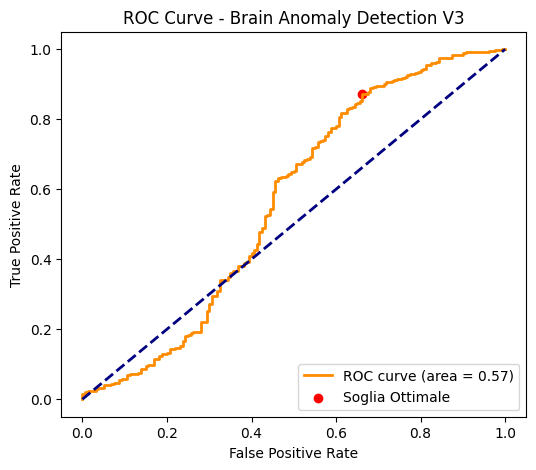

In [47]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import torch

def get_anomaly_scores(model, loader):
    model.eval()
    scores = []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            recon, _, _ = model(batch)
            # Calcoliamo l'errore MSE per ogni singola immagine
            mse = torch.mean((batch - recon)**2, dim=(1, 2, 3))
            scores.extend(mse.cpu().numpy())
    return np.array(scores)

# --- AGGIORNAMENTO V3: Carichiamo il file della V3 ---
# Usiamo il percorso save_path_v3 definito nella cella di training
try:
    model.load_state_dict(torch.load(save_path_v3, map_location=device))
    model.eval()
    print(f"✅ Modello V3 caricato correttamente da: {save_path_v3}")
except NameError:
    # Se la variabile save_path_v3 non esiste, usiamo il percorso manuale
    model_path_v3 = "/content/drive/MyDrive/VAE_Brain_Project/best_model_v3.pth"
    model.load_state_dict(torch.load(model_path_v3, map_location=device))
    model.eval()
    print(f"✅ Modello V3 caricato correttamente da: {model_path_v3}")

# 2. Otteniamo i punteggi (usando i loader creati nella cella precedente)
test_healthy_scores = get_anomaly_scores(model, test_loader_sani)
test_anomaly_scores = get_anomaly_scores(model, anno_loader)

# 3. Creiamo i vettori per la valutazione
y_true = np.array([0] * len(test_healthy_scores) + [1] * len(test_anomaly_scores))
y_scores = np.concatenate([test_healthy_scores, test_anomaly_scores])

# 4. Calcolo della curva ROC e della soglia ottimale (Youden's J)
fpr, tpr, thresholds = roc_curve(y_true, y_scores)

# Calcolo dell'AUC reale
auc_value = roc_auc_score(y_true, y_scores)

# Logica di Youden
j_scores = tpr - fpr
optimal_idx = np.argmax(np.abs(j_scores))
optimal_threshold = thresholds[optimal_idx]

print(f"Soglia ottimale calcolata (Youden): {optimal_threshold:.6f}")
print(f"Miglior compromesso trovato: TPR={tpr[optimal_idx]:.2f}, FPR={fpr[optimal_idx]:.2f}")

# 5. Valutazione finale con correzione automatica inversione
# Se l'errore medio delle anomalie è più basso dei sani, il modello è invertito
is_inverted = np.mean(test_anomaly_scores) < np.mean(test_healthy_scores)

if is_inverted:
    print("⚠️ NOTA: Il modello ricostruisce le anomalie MEGLIO dei sani (Invertito).")
    y_pred = [1 if s < optimal_threshold else 0 for s in y_scores]
    # Se invertito, l'AUC "reale" per l'utente è 1 - auc_value
    display_auc = 1 - auc_value if auc_value < 0.5 else auc_value
else:
    print("✅ Il modello ricostruisce i sani meglio delle anomalie (Corretto).")
    y_pred = [1 if s > optimal_threshold else 0 for s in y_scores]
    display_auc = auc_value

print(f"\n--- PERFORMANCE SUL TEST SET (MODELLO V3) ---")
print(classification_report(y_true, y_pred, target_names=['Sano', 'Anomalia']))
print(f"Area sotto la curva ROC (AUC): {display_auc:.4f}")

# 6. Visualizzazione Curva ROC
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {display_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label='Soglia Ottimale')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Brain Anomaly Detection V3')
plt.legend(loc="lower right")
plt.show()

Media Errore Sani: 0.010245
Media Errore Anomalie: 0.010658


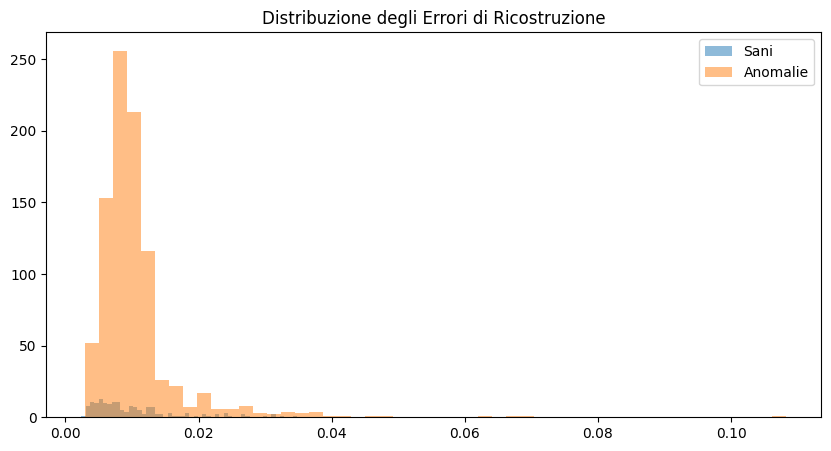

In [48]:
print(f"Media Errore Sani: {test_healthy_scores.mean():.6f}")
print(f"Media Errore Anomalie: {test_anomaly_scores.mean():.6f}")

import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.hist(test_healthy_scores, bins=50, alpha=0.5, label='Sani')
plt.hist(test_anomaly_scores, bins=50, alpha=0.5, label='Anomalie')
plt.legend()
plt.title("Distribuzione degli Errori di Ricostruzione")
plt.show()

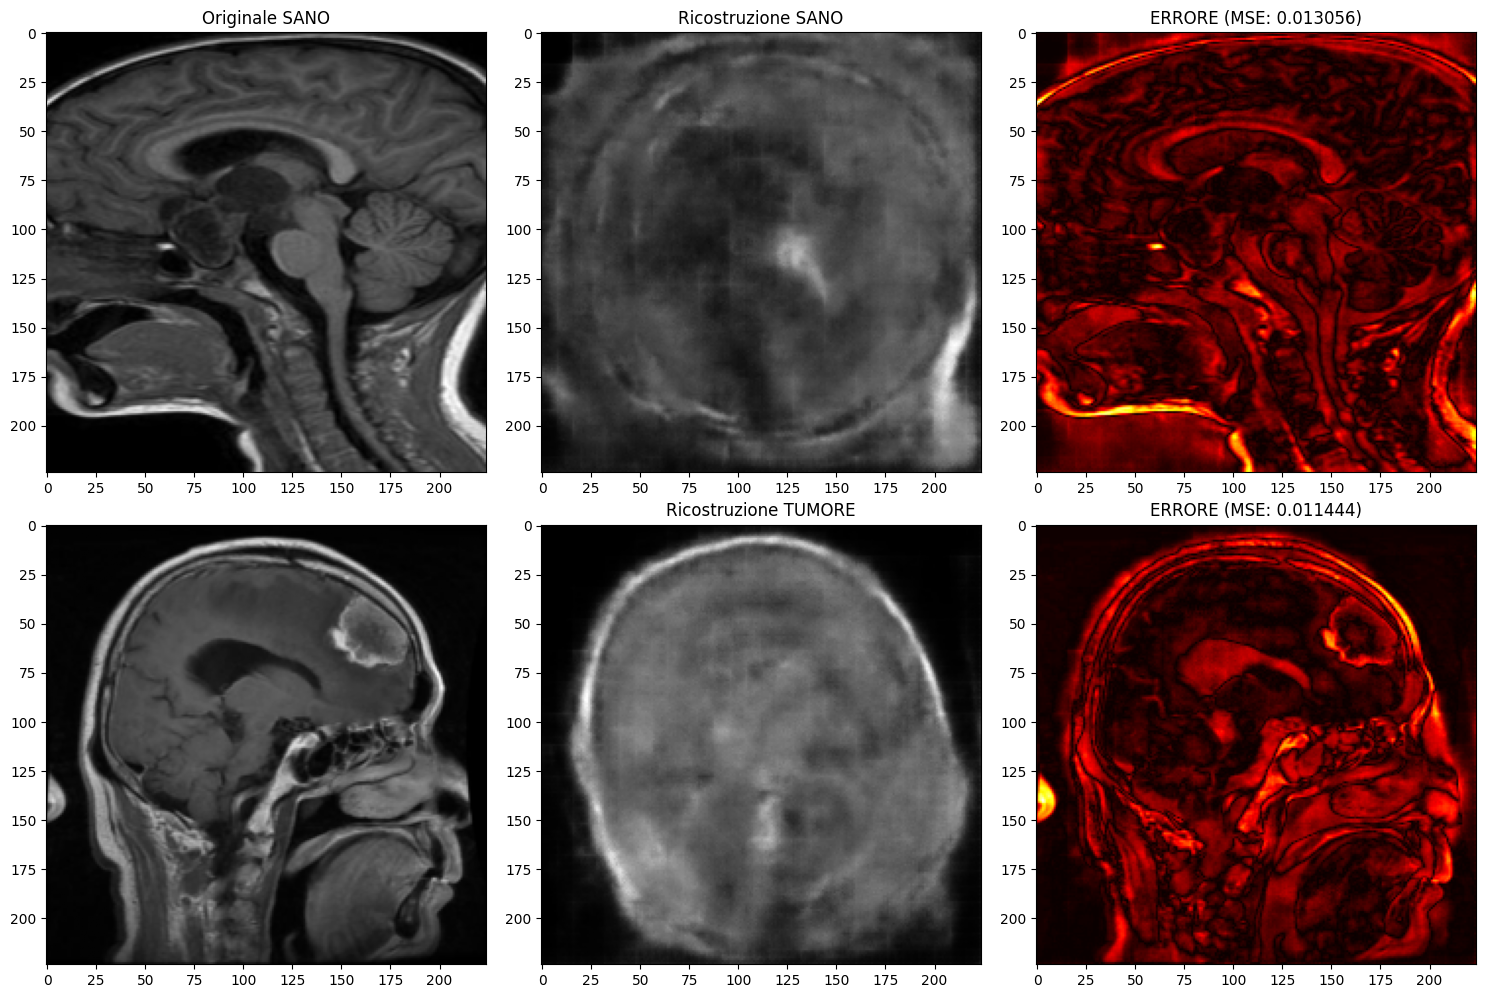

In [49]:
def plot_debug_comparison(model, loader_sani, loader_anno):
    model.eval()
    with torch.no_grad():
        # Prendi un esempio sano e uno anomalo
        img_sano = next(iter(loader_sani))[0:1].to(device)
        img_anno = next(iter(loader_anno))[0:1].to(device)

        # Ricostruzioni
        rec_sano, _, _ = model(img_sano)
        rec_anno, _, _ = model(img_anno)

        # Mappe di differenza (errore assoluto)
        diff_sano = torch.abs(img_sano - rec_sano)
        diff_anno = torch.abs(img_anno - rec_anno)

        # Plotting
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))

        # Riga Sani
        axes[0,0].imshow(img_sano.cpu().squeeze(), cmap='gray'); axes[0,0].set_title("Originale SANO")
        axes[0,1].imshow(rec_sano.cpu().squeeze(), cmap='gray'); axes[0,1].set_title("Ricostruzione SANO")
        axes[0,2].imshow(diff_sano.cpu().squeeze(), cmap='hot'); axes[0,2].set_title(f"ERRORE (MSE: {torch.mean(diff_sano**2):.6f})")

        # Riga Anomalie
        axes[1,0].imshow(img_anno.cpu().squeeze(), cmap='gray'); axes[1,1].set_title("Originale TUMORE")
        axes[1,1].imshow(rec_anno.cpu().squeeze(), cmap='gray'); axes[1,1].set_title("Ricostruzione TUMORE")
        axes[1,2].imshow(diff_anno.cpu().squeeze(), cmap='hot'); axes[1,2].set_title(f"ERRORE (MSE: {torch.mean(diff_anno**2):.6f})")

        plt.tight_layout()
        plt.show()

plot_debug_comparison(model, test_loader_sani, anno_loader)

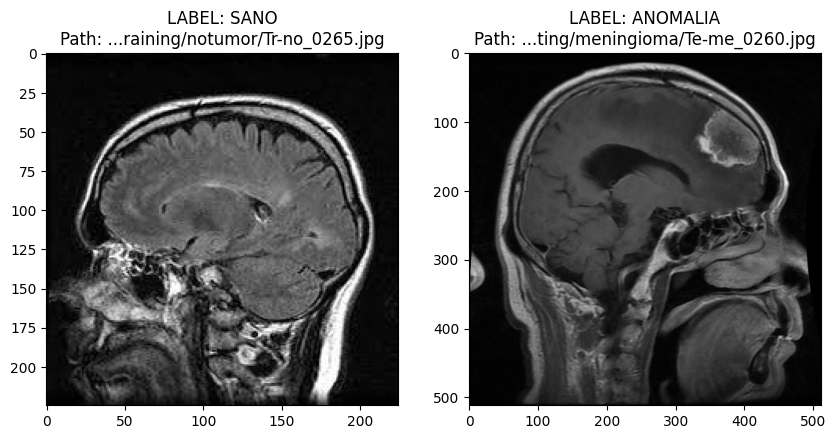

In [50]:
# modello ha assegnato correttamente i labels?
def check_labels_integrity(file_sani_test, file_anomalie_test):
    plt.figure(figsize=(10, 5))

    # Prendi il primo file della lista test sani
    img_sana_path = file_sani_test[0]
    img_sana = Image.open(img_sana_path).convert('L')

    # Prendi il primo file della lista anomalie
    img_anno_path = file_anomalie_test[0]
    img_anno = Image.open(img_anno_path).convert('L')

    plt.subplot(1, 2, 1)
    plt.imshow(img_sana, cmap='gray')
    plt.title(f"LABEL: SANO\nPath: ...{img_sana_path[-30:]}")

    plt.subplot(1, 2, 2)
    plt.imshow(img_anno, cmap='gray')
    plt.title(f"LABEL: ANOMALIA\nPath: ...{img_anno_path[-30:]}")

    plt.show()

# Usiamo le liste originali dei file per il controllo
check_labels_integrity(test_healthy_subset.dataset.file_list, file_anomalie)